In [ ]:
import torch
import os
import glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import math

from IPython.display import Image, clear_output

In [ ]:

if not os.path.exists('./yolov5'):
    !git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%pip install -q roboflow


/content/yolov5


In [ ]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="fMQccUfjPYeTWqAO56At")
project = rf.workspace("aicamp-batch-3").project("safe-steps-wed70")
dataset = project.version(1).download("yolov5")



loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Safe-Steps-1 in yolov5pytorch:: 100%|██████████| 1084/1084 [00:00<00:00, 1511.64it/s]


In [ ]:

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def convertYoloToCoordinates(box, w, h):
    x1 = box[0]-box[2]/2
    y1 = box[1]-box[3]/2
    x2 = box[0]+box[2]/2
    y2 = box[1]+box[3]/2
    return int(x1*w),int(y1*h),int(x2*w),int(y2*h)

In [ ]:
class_labels = ['puddle','street sign','door','person', 'car', 'mailbox', 'stairs','transhcan','walls'] # Replace with your actual class labels


In [ ]:
def drawRect(image, bboxes, labels):
    h, w, ch = image.shape
    font_scale = min(1,max(3,int(w/500)))
    font_thickness = min(2, max(10,int(w/50)))

    for i, box in enumerate(bboxes):
        textWidth, textHeight = cv2.getTextSize(
            labels[i],
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        x1, y1, x2, y2 = convertYoloToCoordinates(box,w,h)
        width = x2 - x2
        height = y2 - y1
        leftTop = (x1,y1)
        rightBottom = (x2, y2)

        cv2.rectangle(image, leftTop, rightBottom,color=(0, 0, 255),thickness=2)

        p1, p2 = tuple(leftTop), tuple(rightBottom)
        vertical_offset = 10
        horizontal_offset = 1
        p2 = p1[0] + textWidth, p1[1] - textHeight - vertical_offset
        cv2.rectangle(image, p1, p2,color=(0, 0, 255),thickness=-1)
        cv2.putText(image, labels[i], (x1 + horizontal_offset, y1 - vertical_offset),
                    cv2.FONT_HERSHEY_SIMPLEX,font_scale,(255, 255, 255),font_thickness)
    return image


In [ ]:
def plotSamples(image_paths, label_paths, num_samples):
    training_data = glob.glob(image_paths)
    labels = glob.glob(label_paths)
    training_data.sort()
    labels.sort()

    no_of_images = len(training_data)

    plt.figure(figsize=(10, 8))
    for i in range(num_samples):
        rand = random.randint(0,no_of_images-1)
        image = cv2.imread(training_data[rand])
        with open(labels[rand], 'r') as f:
            boxes = []
            label_classes = []
            label_lines = f.readlines()
            for label_line in label_lines:
                parts = label_line.split(' ')
                class_id = int(parts[0])
                boundingBox = parts[1:]
                cx, cy, w, h = map(float, boundingBox)
                boxes.append([cx, cy, w, h])
                label_classes.append(class_labels[class_id])  # Append the corresponding class label
        result = drawRect(image, boxes, label_classes)  # Pass the class labels to the drawRect function
        plt.subplot(int(math.sqrt(num_samples)), int(math.sqrt(num_samples)), i+1)
        plt.imshow(result[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()


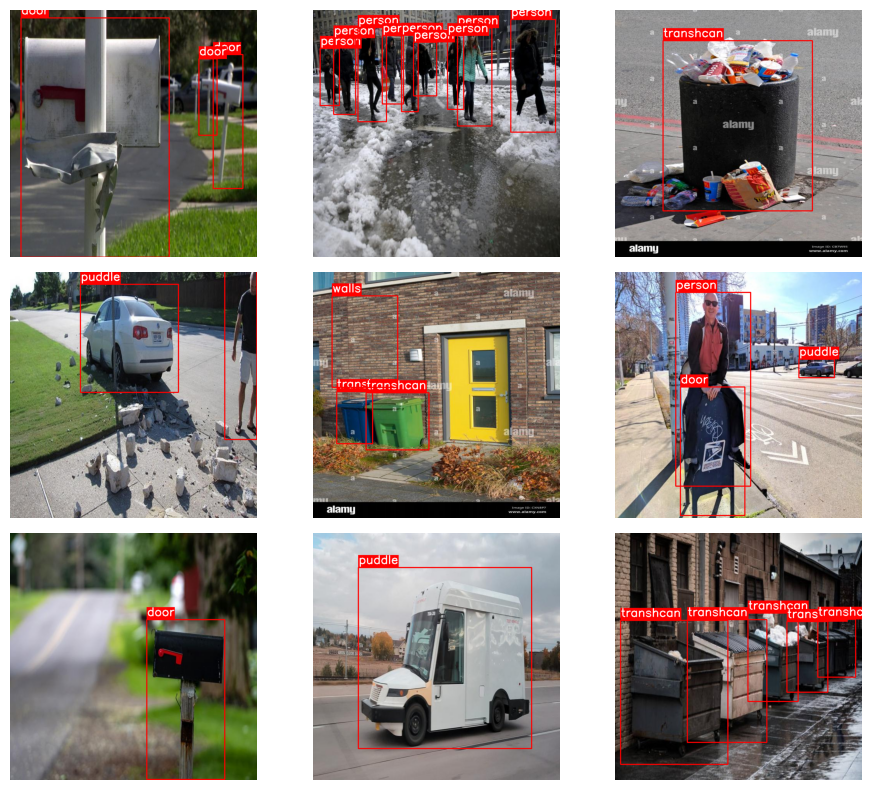

In [ ]:
plotSamples(
    image_paths=f'{dataset.location}/train/images/*',
    label_paths=f'{dataset.location}/train/labels/*',
    num_samples=9,
)

In [ ]:
def generate_results_directory():
    count = len(glob.glob('./runs/train/*'))
    return f"results_{count+1}"

In [ ]:
results_directory = generate_results_directory()
!python3 train.py --img 224 --batch-size 16 --epochs 30 --data {dataset.location}/data.yaml \
                  --name {results_directory} --weights yolov5l.pt \
                  --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13

train: weights=yolov5l.pt, cfg=, data=/content/yolov5/Safe-Steps-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-203-g0897415 Python-3.10.12 torch-2.0.1+cu118 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.

In [ ]:
from google.colab import files

def download_results(folder_path):
  basename = os.path.basename(folder_path)
  zip_name = f'{basename}.zip'
  !zip -r {zip_name} {folder_path}
  files.download(zip_name)

In [ ]:
results_directory = f'runs/train/{results_directory}'

In [ ]:
download_results(results_directory)

In [ ]:
!python3 detect.py --weights {results_directory}/weights/best.pt \
                  --img 224 --conf 0.5 --source {dataset.location}/test/images

In [ ]:
download_results("runs/detect/exp2")

